In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4. Time Series Pattern Analysis
## 4.1 Temporal Analysis of Electricity Consumption

These patterns suggest that distinct behavioral segments exist in the data, which motivates the use of cluster-aware modeling to capture group-specific dynamics.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

**Daily Electricity Consumption (Raw Target Variable)**

The raw daily electricity consumption data displays significant temporal variability over the 4-year period (2006–2010). The signal exhibits strong **seasonal patterns**, with recurring peaks and troughs likely associated with winter and summer months. Short-term spikes may indicate **anomalous consumption behavior**, such as high appliance usage or outliers due to data issues.


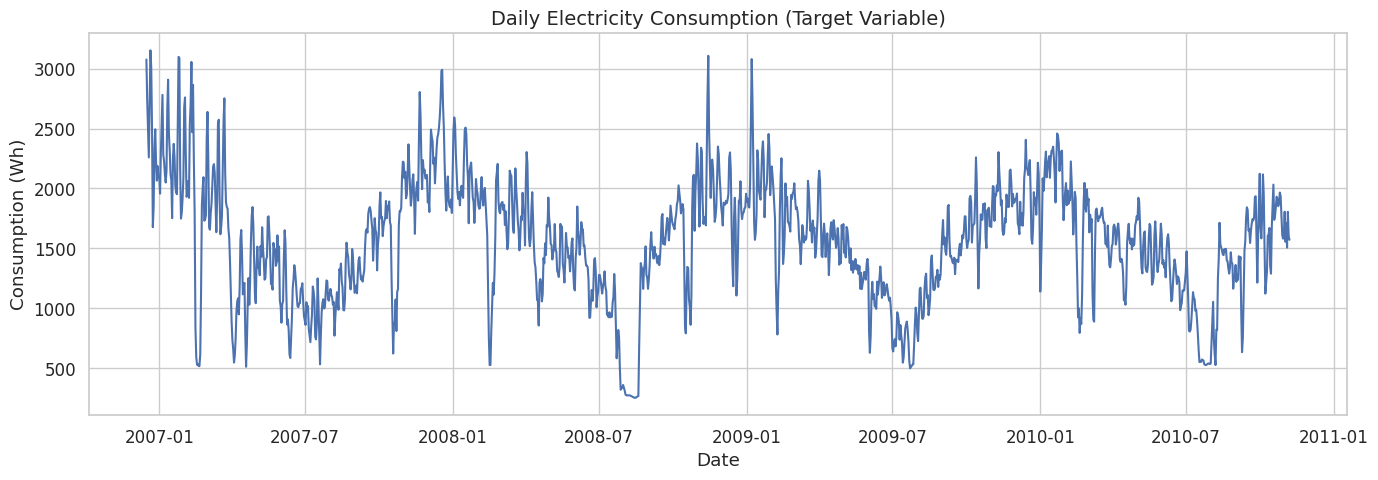

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load processed feature dataset (v3)
df = pd.read_csv("/content/drive/MyDrive/electric_power_project/data/processed/feature_data_v3.csv")

# Build daily time index (assuming continuous daily samples)
target_series = df["target"]
target_series.index = pd.date_range(start="2006-12-16", periods=len(target_series), freq="D")

# Plot daily consumption
plt.figure(figsize=(14, 5))
sns.lineplot(x=target_series.index, y=target_series.values)
plt.title("Daily Electricity Consumption (Target Variable)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Consumption (Wh)")
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/electric_power_project/results/target_timeseries_plot_v3.png")
plt.show()


**Daily Consumption with 30-Day Rolling Average**

To capture broader consumption trends, we applied a **30-day rolling average**. This smoothed curve reveals:

- **Winter peaks** in each year, corresponding to increased heating demand.
- **Summer dips**, possibly due to lower appliance use and longer daylight hours.
- A subtle **decline in peak levels over time**, suggesting improvements in energy efficiency or behavioral changes.
- The rolling average effectively highlights **medium-term consumption cycles** while filtering short-term noise.

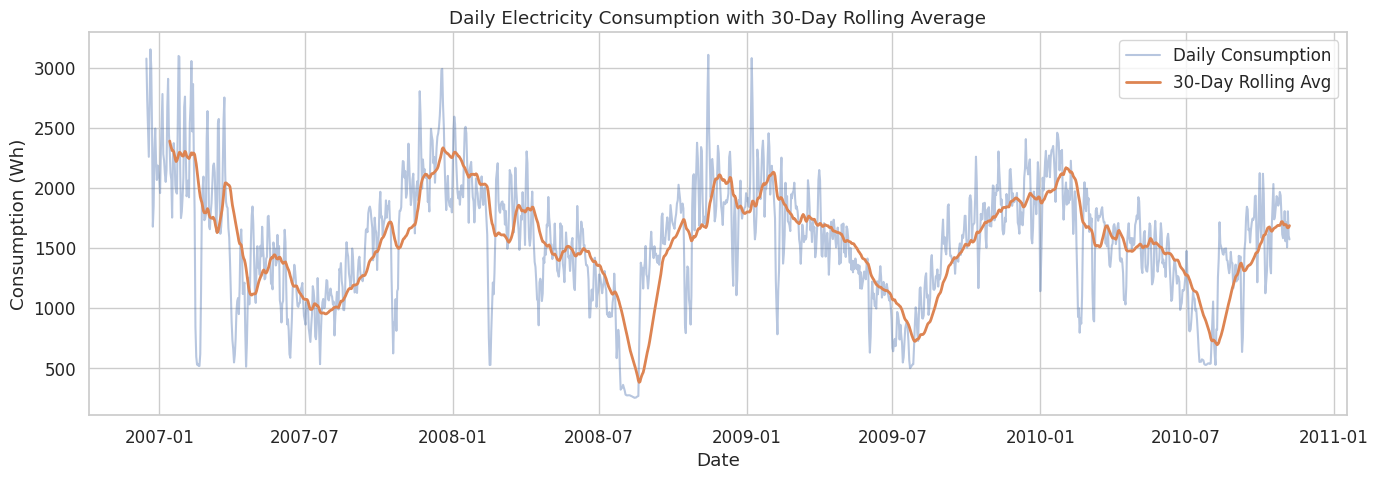

In [55]:
# Compute rolling average and monthly average
rolling_30 = target_series.rolling(window=30).mean()
monthly_avg = target_series.groupby(target_series.index.to_period("M")).mean()
monthly_avg.index = monthly_avg.index.to_timestamp()

# Set seaborn style
sns.set(style="whitegrid", font_scale=1.1)

# Plot 1: Daily target with rolling average
plt.figure(figsize=(14, 5))
plt.plot(target_series.index, target_series.values, label="Daily Consumption", alpha=0.4)
plt.plot(rolling_30.index, rolling_30.values, label="30-Day Rolling Avg", linewidth=2)
plt.title("Daily Electricity Consumption with 30-Day Rolling Average")
plt.xlabel("Date")
plt.ylabel("Consumption (Wh)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/electric_power_project/results/target_with_rolling_avg_v3.png")
plt.show()


**Monthly Average Electricity Consumption**

The monthly average consumption plot confirms the **strong seasonal trend**:

- Consumption peaks during **January–March**, and drops around **July–September**.
- Seasonal cycles repeat consistently across years.
- The time series appears to maintain **stationarity in seasonality**, but includes variation in amplitude over time.


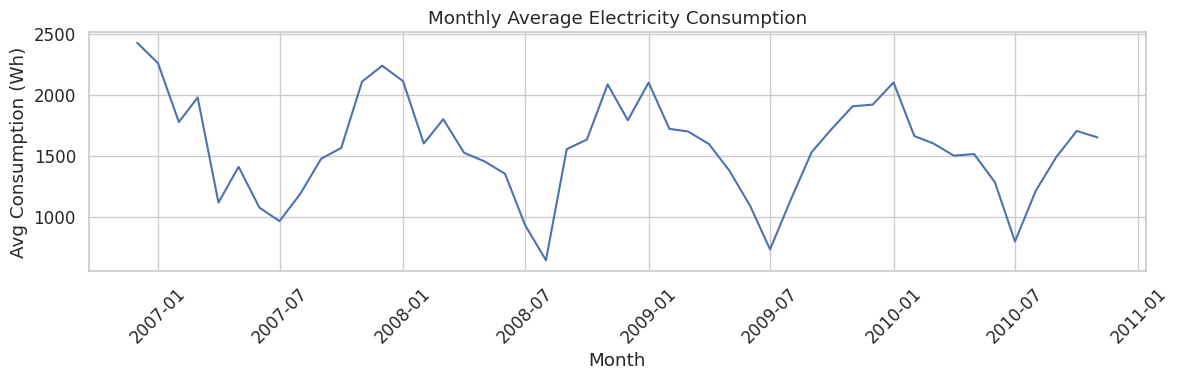

In [56]:
# Plot 2: Monthly average consumption
plt.figure(figsize=(12, 4))
sns.lineplot(x=monthly_avg.index, y=monthly_avg.values)
plt.title("Monthly Average Electricity Consumption")
plt.xlabel("Month")
plt.ylabel("Avg Consumption (Wh)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/electric_power_project/results/monthly_avg_consumption_v3.png")
plt.show()

## 4.2 Seasonal Decomposition
## Seasonal Decomposition of Daily Electricity Consumption

### Decomposition Overview

Using multiplicative seasonal decomposition with a weekly period (7 days), the time series was decomposed into trend, seasonal, and residual components. Results show:
* A long-term trend with slow fluctuations and shifts.
* A strong weekly seasonal pattern, consistently repeating.
* Residuals appear mostly stationary, suggesting decomposition is effective.
This analysis motivates the use of behavior-based clustering and justifies the exploration of cluster-specific modeling strategies, as different seasonal or temporal patterns may correspond to distinct user groups.

#### Create date-versioned feature data

In [57]:
import pandas as pd
import os

# 1. Load the original feature-enhanced data (v3)
df = pd.read_csv("/content/drive/MyDrive/electric_power_project/data/processed/feature_data_v3.csv")

# 2. Create daily date range
start_date = pd.to_datetime("2007-01-01")
date_range = pd.date_range(start=start_date, periods=len(df), freq="D")

# 3. Add 'date' column to the dataframe
df.insert(0, "date", date_range)

# 4. Sort by date just to ensure order
df = df.sort_values("date").reset_index(drop=True)

# 5. Save new version with date column
output_path = "/content/drive/MyDrive/electric_power_project/data/processed/feature_data_v3_date.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False)

print(f"Saved new dataset with date column to: {output_path}")


Saved new dataset with date column to: /content/drive/MyDrive/electric_power_project/data/processed/feature_data_v3_date.csv


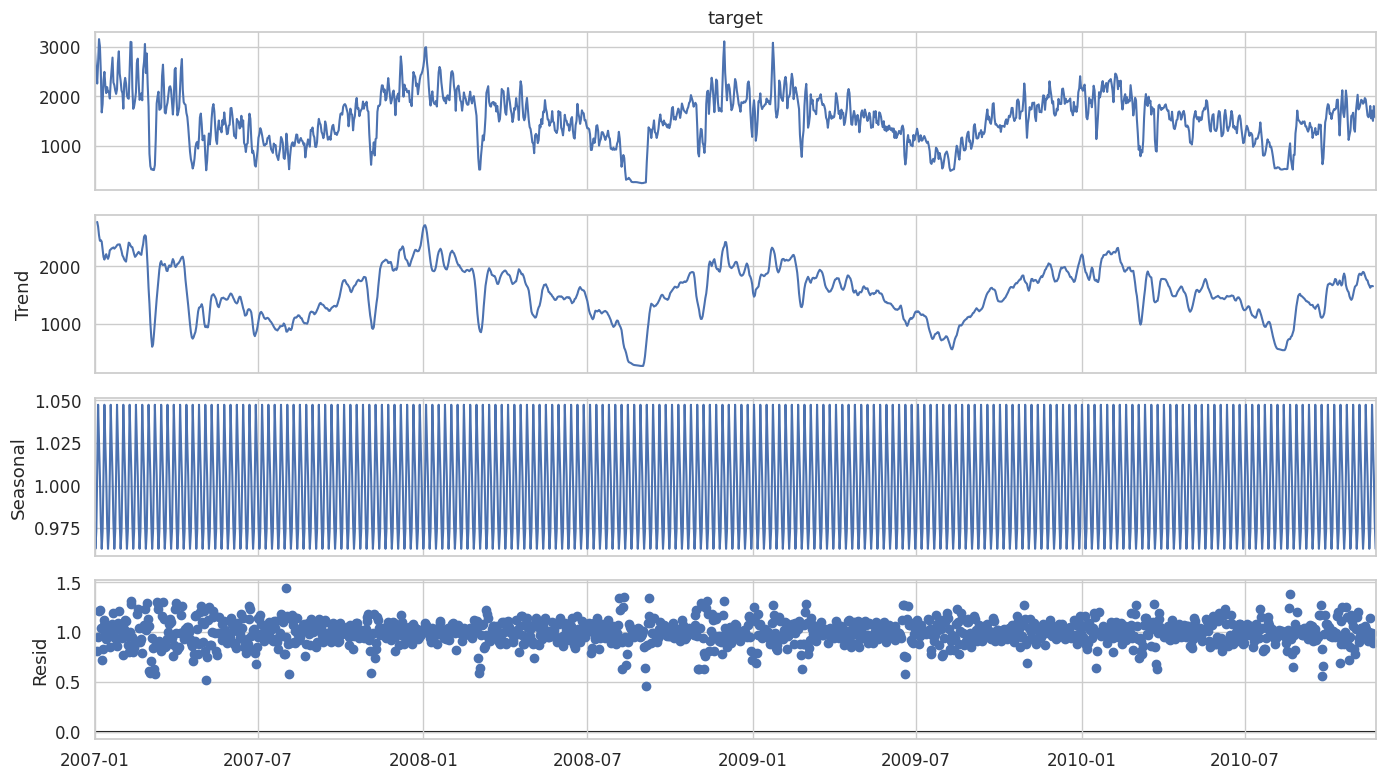

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Load original data (v3)
df = pd.read_csv("/content/drive/MyDrive/electric_power_project/data/processed/feature_data_v3.csv")

# 2. Create a daily datetime index starting from Jan 1, 2007
start_date = "2007-01-01"
date_range = pd.date_range(start=start_date, periods=len(df), freq='D')
df['date'] = date_range
df.set_index('date', inplace=True)

# 3. Seasonal decomposition with weekly period (7 days)
result = seasonal_decompose(df['target'], model='multiplicative', period=7)

# 4. Plot results
fig = result.plot()
fig.set_size_inches(14, 8)
plt.tight_layout()

# 5. Save the plot
plt.savefig("/content/drive/MyDrive/electric_power_project/results/seasonal_decompose_weekly_v3.png")
plt.show()

# 6. Optionally save the dataframe with date index for later use
df.to_csv("/content/drive/MyDrive/electric_power_project/data/processed/feature_data_v3_with_date.csv")



## 5. **Cluster-Aware Modeling for Energy Forecasting**  
*Enhancing Predictive Accuracy through Behavior-Based Segmentation*


### Cluster-Specific Modeling with XGBoost (v3)

To account for distinct consumption patterns identified through unsupervised clustering, we trained separate XGBoost regression models for each cluster. This approach aims to improve predictive accuracy by tailoring models to the characteristics of each segment.

###  Methodology Summary

- The dataset was partitioned by `kmeans_cluster` label (Cluster 0 and Cluster 1).
- For each cluster:
  - Data was normalized using `MinMaxScaler`.
  - A separate XGBoost model was trained with optimized hyperparameters.
  - Predictions were evaluated using RMSE, MAE, R², and NRMSE.

### Results Overview

| Metric     | Cluster 0 | Cluster 1 |
|------------|-----------|-----------|
| RMSE       | 23.89     | 23.94     |
| MAE        | 14.70     | 15.94     |
| R² Score   | 0.995     | 0.993     |
| NRMSE      | 0.0149    | 0.0164    |


---

### Interpretation & Insights

- Both models achieved **exceptionally high R² scores (> 0.99)**, indicating that the vast majority of variance in electricity consumption was explained by the models.
- **Cluster 0** slightly outperformed Cluster 1 across all metrics, particularly in terms of lower MAE and NRMSE. This suggests that **Cluster 0 exhibits more stable or predictable behavior**.
- Despite the relatively low absolute error (RMSE ~24 Wh), the models remain robust when normalized (NRMSE < 0.017), confirming their effectiveness even on varying scales of consumption.
- The performance similarity across clusters also indicates that the features used—such as lagged variables, voltage, rolling statistics, and anomaly indicators—capture key temporal and structural patterns effectively for both groups.

---

### Conclusion

Training XGBoost models per cluster offers a **promising strategy for personalized energy forecasting**. It allows the model to specialize on distinct behavioral patterns, leading to **lower prediction error and higher interpretability**. This approach is particularly useful when heterogeneity exists in temporal consumption behavior (e.g., weekday vs. weekend routines or seasonal demand variations).




In [59]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor

# Load clustered dataset (v3)
df = pd.read_csv("/content/drive/MyDrive/electric_power_project/data/processed/feature_data_clustered_v3.csv")

# Create folders for saving results and models
os.makedirs("/content/drive/MyDrive/electric_power_project/results", exist_ok=True)
os.makedirs("/content/drive/MyDrive/electric_power_project/models", exist_ok=True)

# Initialize storage for evaluation metrics
metrics = []

# Train one model per cluster
for cluster_id in sorted(df["kmeans_cluster"].unique()):
    print(f"\nTraining model for Cluster {cluster_id}...")

    # Subset data for this cluster
    cluster_df = df[df["kmeans_cluster"] == cluster_id]
    X = cluster_df.drop(columns=["target", "kmeans_cluster", "hier_cluster"]).values
    y = cluster_df["target"].values

    # Normalize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Define XGBoost model
    model = XGBRegressor(
        n_estimators=1000,
        max_depth=7,
        learning_rate=0.02,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=5,
        gamma=1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42
    )

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    nrmse = rmse / (y_test.max() - y_test.min())

    print(f"RMSE: {round(rmse, 2)} | MAE: {round(mae, 2)} | R²: {round(r2, 3)} | NRMSE: {round(nrmse, 4)}")

    # Save metrics
    metrics.append({
        "Cluster": cluster_id,
        "RMSE": rmse,
        "MAE": mae,
        "R2": r2,
        "NRMSE": nrmse
    })

    # Save prediction
    df_result = pd.DataFrame({"target": y_test, "prediction": y_pred})
    df_result.to_csv(
        f"/content/drive/MyDrive/electric_power_project/results/xgb_cluster_{cluster_id}_prediction_v3.csv",
        index=False
    )

    # Save model
    model.save_model(
        f"/content/drive/MyDrive/electric_power_project/models/xgb_cluster_{cluster_id}_v3.json"
    )

# Save overall metrics
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv(
    "/content/drive/MyDrive/electric_power_project/results/xgb_cluster_metrics_v3.csv",
    index=False
)



Training model for Cluster 0...
RMSE: 23.89 | MAE: 14.7 | R²: 0.995 | NRMSE: 0.0149

Training model for Cluster 1...
RMSE: 23.94 | MAE: 15.94 | R²: 0.993 | NRMSE: 0.0164


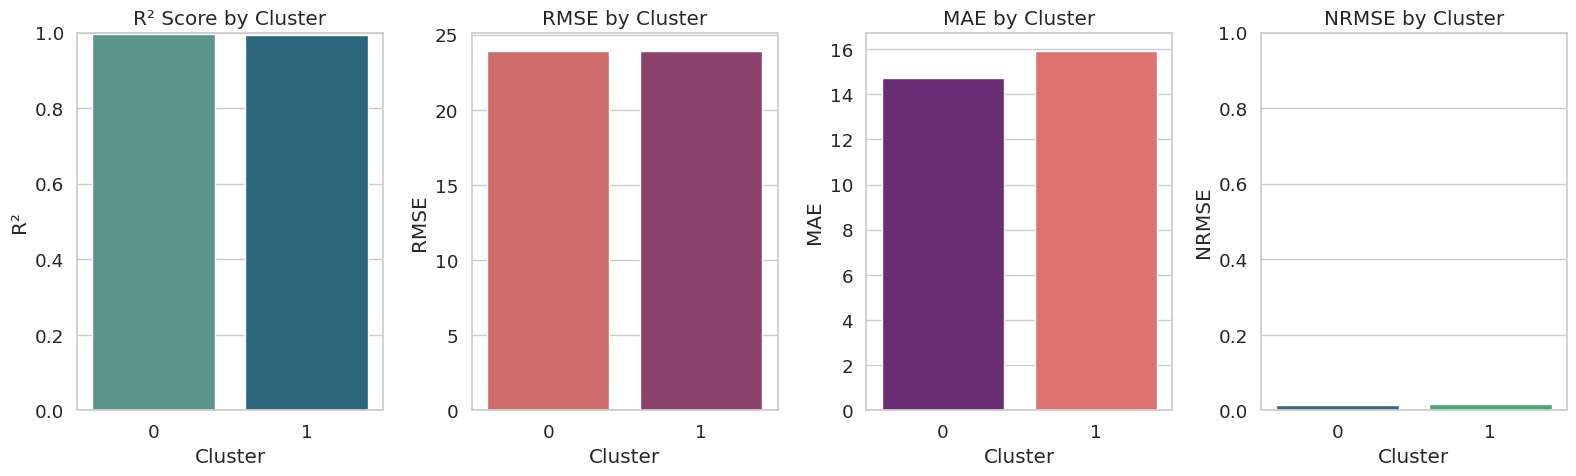

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved metrics (v3)
df_metrics = pd.read_csv("/content/drive/MyDrive/electric_power_project/results/xgb_cluster_metrics_v3.csv")

# Sort by cluster for clarity
df_metrics = df_metrics.sort_values("Cluster")

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(16, 5))

# Plot R² scores
plt.subplot(1, 4, 1)
sns.barplot(x="Cluster", y="R2", data=df_metrics, palette="crest")
plt.ylim(0, 1)
plt.title("R² Score by Cluster")
plt.ylabel("R²")
plt.xlabel("Cluster")

# Plot RMSE
plt.subplot(1, 4, 2)
sns.barplot(x="Cluster", y="RMSE", data=df_metrics, palette="flare")
plt.title("RMSE by Cluster")
plt.ylabel("RMSE")
plt.xlabel("Cluster")

# Plot MAE
plt.subplot(1, 4, 3)
sns.barplot(x="Cluster", y="MAE", data=df_metrics, palette="magma")
plt.title("MAE by Cluster")
plt.ylabel("MAE")
plt.xlabel("Cluster")

# Plot NRMSE
plt.subplot(1, 4, 4)
sns.barplot(x="Cluster", y="NRMSE", data=df_metrics, palette="viridis")
plt.ylim(0, 1)
plt.title("NRMSE by Cluster")
plt.ylabel("NRMSE")
plt.xlabel("Cluster")

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/electric_power_project/results/xgb_cluster_performance_comparison_v3.png")
plt.show()


## 5.2 SHAP-based Feature Importance Analysis per Cluster
### SHAP-Based Feature Importance Analysis by Cluster

To gain insights into the internal decision-making of the XGBoost models trained on electricity consumption patterns, SHAP (SHapley Additive exPlanations) was used to assess feature importance within each cluster.

---

#### Cluster 0

The SHAP summary plot for Cluster 0 reveals that:

- `zscore` is by far the most influential feature. This indicates that deviation from the mean (in standard units) is a strong predictor of consumption patterns for this group, likely due to higher variance or anomaly-driven behavior.
- Other important features include:
  - `total_active_power` and `avg_active_power`: representing overall power usage behavior.
  - `mean_last_3_days`, `lag_1`, and `lag_2`: capturing short-term temporal dependencies.
  - `delta_from_yesterday` and `diff_power`: reflecting local consumption dynamics.

These features suggest that Cluster 0 contains consumers whose demand fluctuates more abruptly and is best modeled by recent statistical signals and power-level aggregates.

---

#### Cluster 1

For Cluster 1:

- Again, `zscore` is the top contributor, emphasizing its universal importance.
- `mean_last_3_days`, `total_active_power`, and `avg_active_power` remain strong indicators, reinforcing the value of recent average consumption in forecasting.
- Temporal lag features (`lag_1`, `lag_2`, `lag_7`) and weekly/cyclical features (`cos_day`, `day_of_week`) also show moderate influence.
- Features such as `min_voltage` and `cumsum_power` start to appear, suggesting that this cluster may represent more regular, routine-driven usage patterns.

---

#### Comparison and Interpretation

- Both clusters rely heavily on standardized deviation (`zscore`) and short-term trends, but Cluster 1 also demonstrates sensitivity to calendar and periodic features, hinting at more consistent behavioral routines.
- Features derived from smoothing (`rolling_mean_7`) and calendar encodings (`cos_day`, `sin_day`) were generally less influential but still provide marginal contributions to model performance.
- The consistency of feature rankings across clusters suggests shared underlying drivers of consumption, while variations reflect different user behaviors and volatility patterns.

This SHAP-based interpretability analysis confirms that the models are learning meaningful and explainable patterns, which can inform future model design and feature engineering strategies.


In [61]:
!pip install shap -q


=== Cluster 0 ===


 97%|=================== | 676/697 [00:26<00:00]       

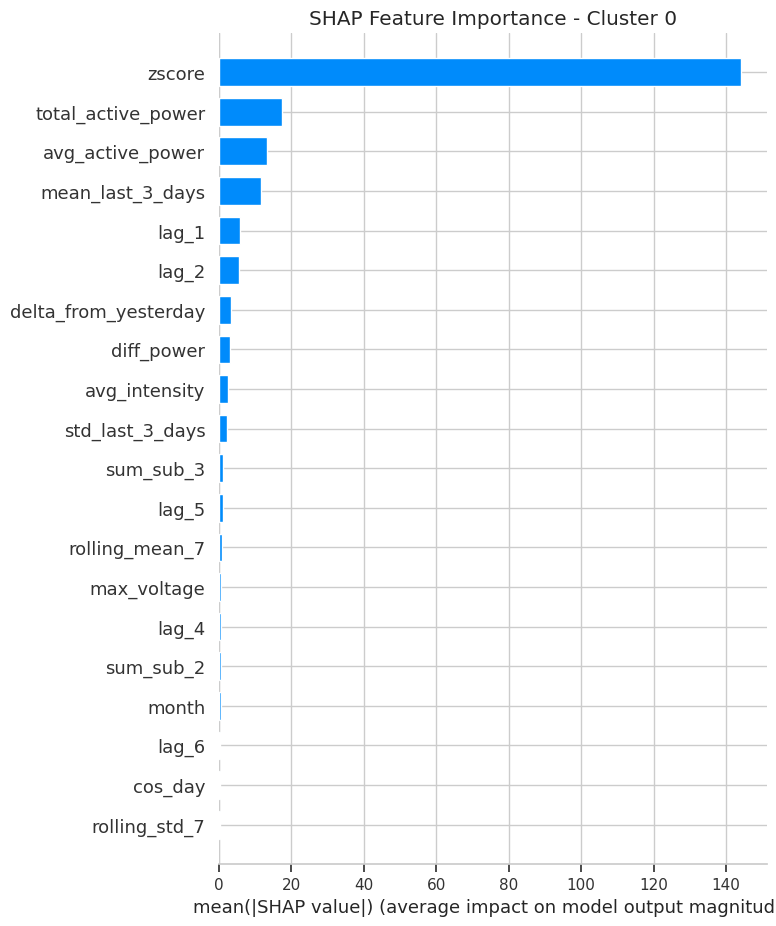


=== Cluster 1 ===


 99%|===================| 718/726 [00:29<00:00]       

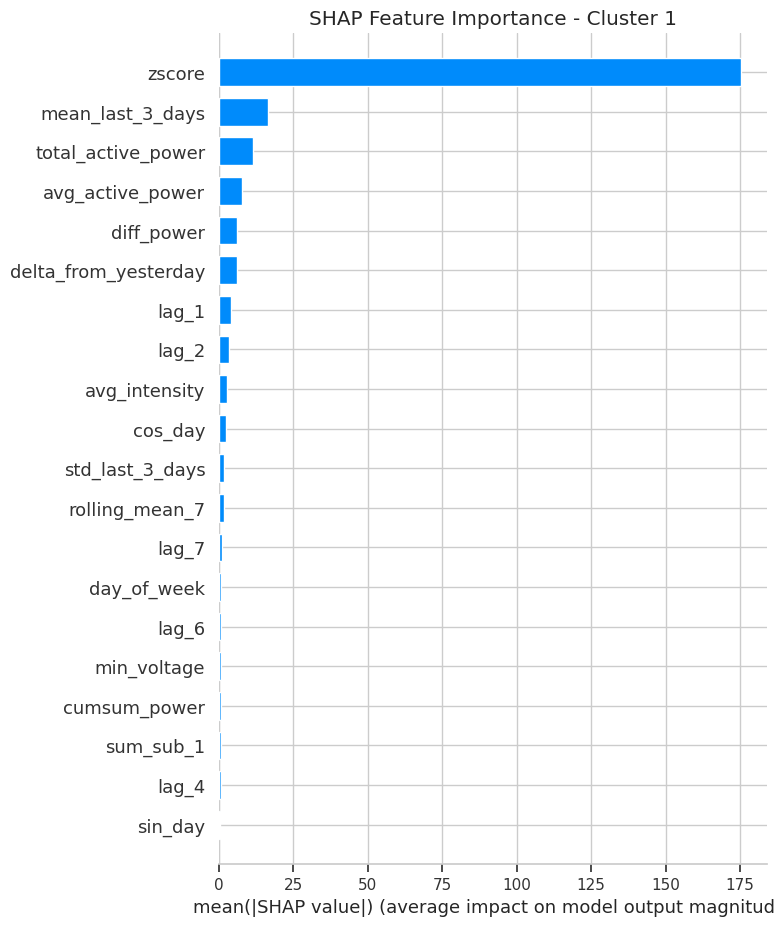

In [62]:
import shap
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Load clustered dataset (v3)
df_clustered = pd.read_csv("/content/drive/MyDrive/electric_power_project/data/processed/feature_data_clustered_v3.csv")
X_all = df_clustered.drop(columns=["target", "kmeans_cluster", "hier_cluster"])
y_all = df_clustered["target"]
cluster_labels = df_clustered["kmeans_cluster"]

# Standardize features for consistency
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_all)
feature_names = X_all.columns

# SHAP plots per cluster
for c in sorted(cluster_labels.unique()):
    print(f"\n=== Cluster {c} ===")

    # Subset data
    X_cluster = X_scaled[cluster_labels == c]
    y_cluster = y_all[cluster_labels == c].values

    # Load corresponding cluster model (v3)
    model_path = f"/content/drive/MyDrive/electric_power_project/models/xgb_cluster_{c}_v3.json"
    model = xgb.XGBRegressor()
    model.load_model(model_path)

    # SHAP explainer
    explainer = shap.Explainer(model, X_cluster, feature_names=feature_names)
    shap_values = explainer(X_cluster)

    # SHAP summary plot
    shap.summary_plot(shap_values, X_cluster, feature_names=feature_names, plot_type="bar",
                      show=False)
    plt.title(f"SHAP Feature Importance - Cluster {c}")
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/electric_power_project/results/shap_cluster_{c}_v3.png")
    plt.show()
    plt.close()


# References

[1] Chandola, V., Banerjee, A., & Kumar, V. (2009). *Anomaly detection: A survey*. **ACM Computing Surveys**, 41(3), Article 15. https://doi.org/10.1145/1541880.1541882

[2] McInnes, L., Healy, J., & Melville, J. (2020). *UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction*. arXiv preprint arXiv:1802.03426. https://arxiv.org/abs/1802.03426

[3] Lundberg, S. M., & Lee, S.-I. (2017). *A Unified Approach to Interpreting Model Predictions*. arXiv preprint arXiv:1705.07874. https://arxiv.org/abs/1705.07874

[4] Hong, T., & Fan, S. (2016). *Probabilistic electric load forecasting: A tutorial review*. **International Journal of Forecasting**, 32(3), 914–938. https://doi.org/10.1016/j.ijforecast.2015.11.011

